In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
from random import random
from tqdm.notebook import tqdm

In [ ]:
import time
import multiprocess as mp

### Read data & preprocessing

In [ ]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [ ]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

### Mutation detection

In [ ]:
from mutation_detection import *
from LOH_detection import *

In [ ]:
ref = df_ref.to_numpy(dtype = float)
alt = df_alt.to_numpy(dtype = float)
coverages = ref.flatten() + alt.flatten()

In [ ]:
ref.shape

In [ ]:
(1 - 1/(2*1168 - 2)**2) ** 16153

In [ ]:
get_composition_priors(10, genotype_freq = {'R': 1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)

In [ ]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

In [ ]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [ ]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [ ]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

In [ ]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Data Generator

In [1]:
from data_generator import *

In [2]:
dg = DataGenerator(6, 20)

In [3]:
ref, alt, gt1, gt2 = dg.generate_reads()

  0%|          | 0/6 [00:00<?, ?it/s]

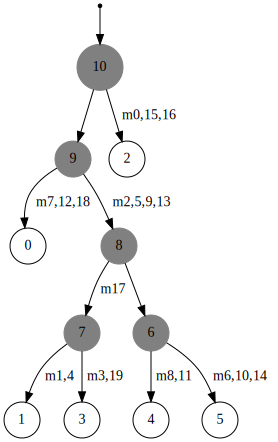

In [4]:
dg.tree.to_graphviz()

### Tree Inference

In [5]:
from tree_inference import TreeOptimizer

In [6]:
optz = TreeOptimizer()
optz.fit(ref, alt, gt1, gt2, reversible = True)

In [7]:
optz.optimize()

([-159.3177320788121,
  -147.34318962284672,
  -145.4732339495487,
  -143.01495238243282,
  -142.81880190106713,
  -142.81880190106713,
  -142.81880190106713],
 [0, 0, 0, 0, 0, 1, 0])

In [8]:
optz.ct_joint

-142.81880190106713

In [9]:
optz.mt_joint

-142.81880190106713

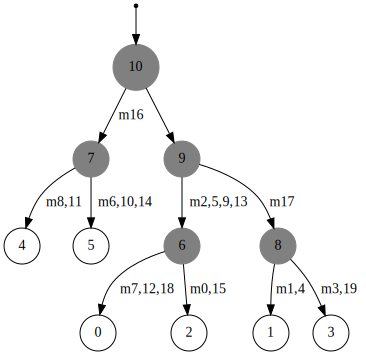

In [10]:
optz.ct.to_graphviz()

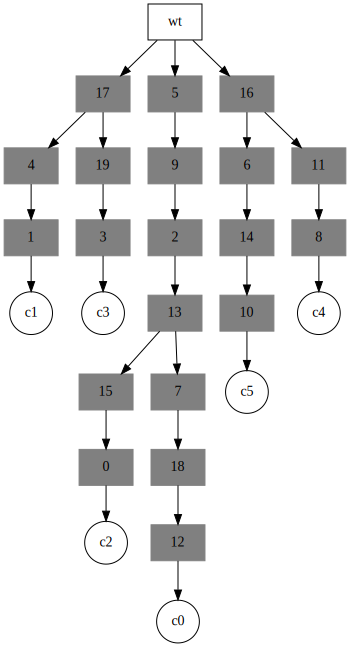

In [11]:
optz.mt.to_graphviz()